# Models 11
*Anders Poirel*

In [2]:
%cd ..

C:\Users\Anders\Documents\data-science-projects\dss-diseasespread


In [240]:
import numpy as np
import pandas as pd 
import os 

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_validate, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.models.utilities import build_submission

In [243]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150,
})
sns.set()


## Reading the data

In [79]:
DATA_PATH = 'data/processed'
MODEL_PATH = 'models'
PRED_PATH = 'models'

In [86]:
X_train_1 = pd.read_csv(os.path.join(DATA_PATH, 'stacking_features/lag52_negbin_train.csv'))
X_train_2 = pd.read_csv(os.path.join(DATA_PATH, 'stacking_features/prog_and_lag_train.csv'))

X_test_1 = pd.read_csv(os.path.join(MODEL_PATH, 'lag52_negbin.csv'))
X_test_2 = pd.read_csv(os.path.join(MODEL_PATH, 'prog_and_lag.csv'))

y_train = pd.read_csv(os.path.join(DATA_PATH, 'lag52_train_labels.csv'))

Remove rows unavailable in `X_train_1` (due to being built on lagged data)

In [87]:
X_train_2_sj = X_train_2[X_train_2['city'] == 'sj'].iloc[52:,:]
X_train_2_iq = X_train_2[X_train_2['city'] == 'iq'].iloc[52:,:]

X_train_2 = (pd.concat([X_train_2_sj, X_train_2_iq], axis = 0)
            .reset_index(drop = True)
            .rename({'city': 'city2'}, axis = 1)
            )

X_train = pd.concat([X_train_1, X_train_2], axis = 1).drop('city2', axis = 1)

Merge `X_test_1` and `X_test_2`

In [88]:
X_test_1['total_cases_2'] = X_test_2['total_cases']
X_test = X_test_1.drop(['year', 'weekofyear'], axis = 1)

Seperate by city

In [212]:
X_train_sj = X_train[X_train['city'] == 'sj'].drop('city', axis = 1)
X_train_iq = X_train[X_train['city'] == 'iq'].drop('city', axis = 1)

X_test_sj = X_test[X_test['city'] == 'sj'].drop('city', axis = 1)
X_test_iq = X_test[X_test['city'] == 'iq'].drop('city', axis = 1)

y_train_sj = y_train[y_train['city'] == 'sj']['total_cases'].astype('float')
y_train_iq = y_train[y_train['city'] == 'iq']['total_cases'].astype('float')

## Models

### San Juan

In [207]:
model_sj = Pipeline([
    ('scale', StandardScaler()),
    ('lin', Ridge(240))
])

In [208]:
cv_sj = cross_validate(
    estimator = model_sj,
    scoring = 'neg_mean_absolute_error',
    X = X_train_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(5),
    n_jobs = -1,
)

print(np.mean(cv_sj['test_score']))
print(np.std(cv_sj['test_score']))

-29.089137396003913
9.558096187803567


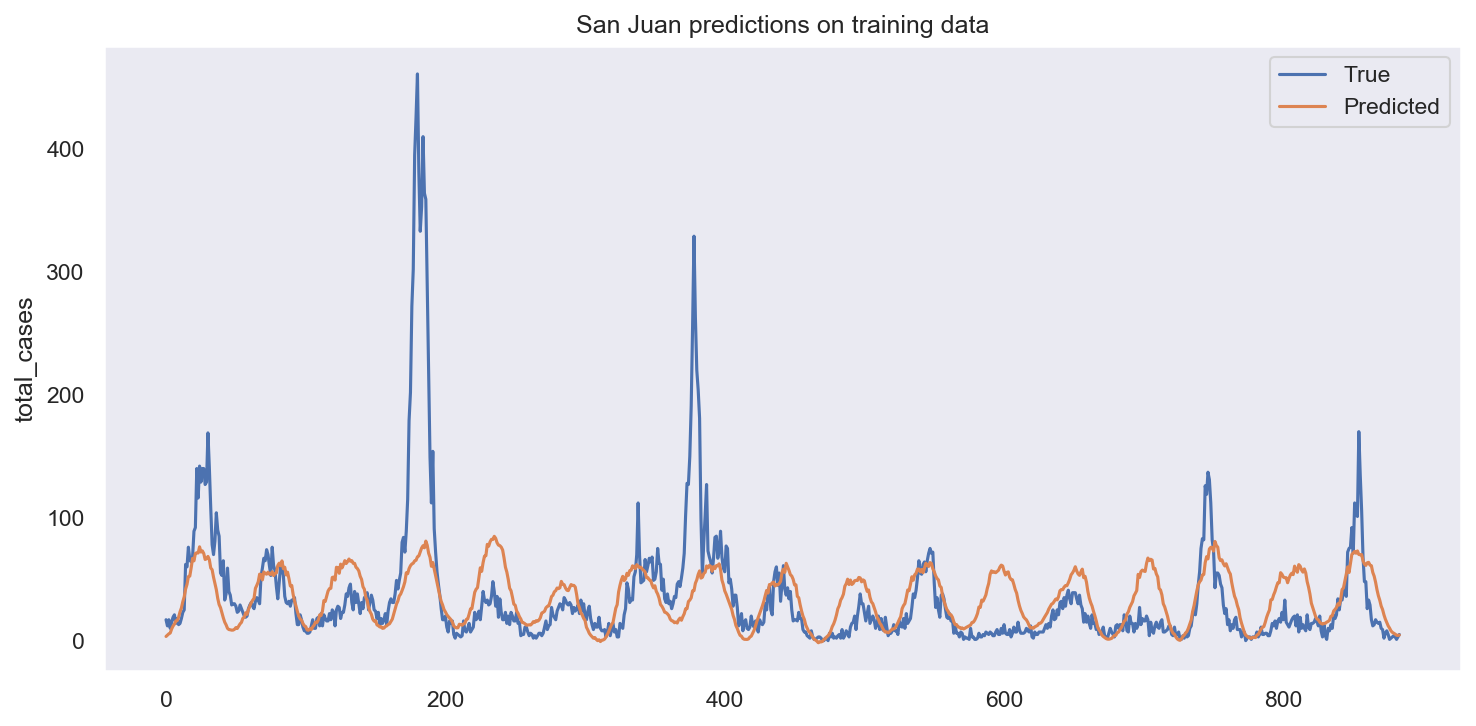

In [244]:
model_sj.fit(X_train_sj, y_train_sj)
y_val_sj = model_sj.predict(X_train_sj)
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = X_train_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = X_train_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

In [192]:
model_iq = Pipeline([
    ('scale', StandardScaler()),
    ('lin', Ridge(80))  
])

In [193]:
cv_iq = cross_validate(
    estimator = model_iq,
    X = X_train_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(5),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 100
)
print(np.mean(cv_iq['test_score']))
print(np.std(cv_iq['test_score']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0010s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
-5.8953044806330706
1.4475171423782314


#### Visualization

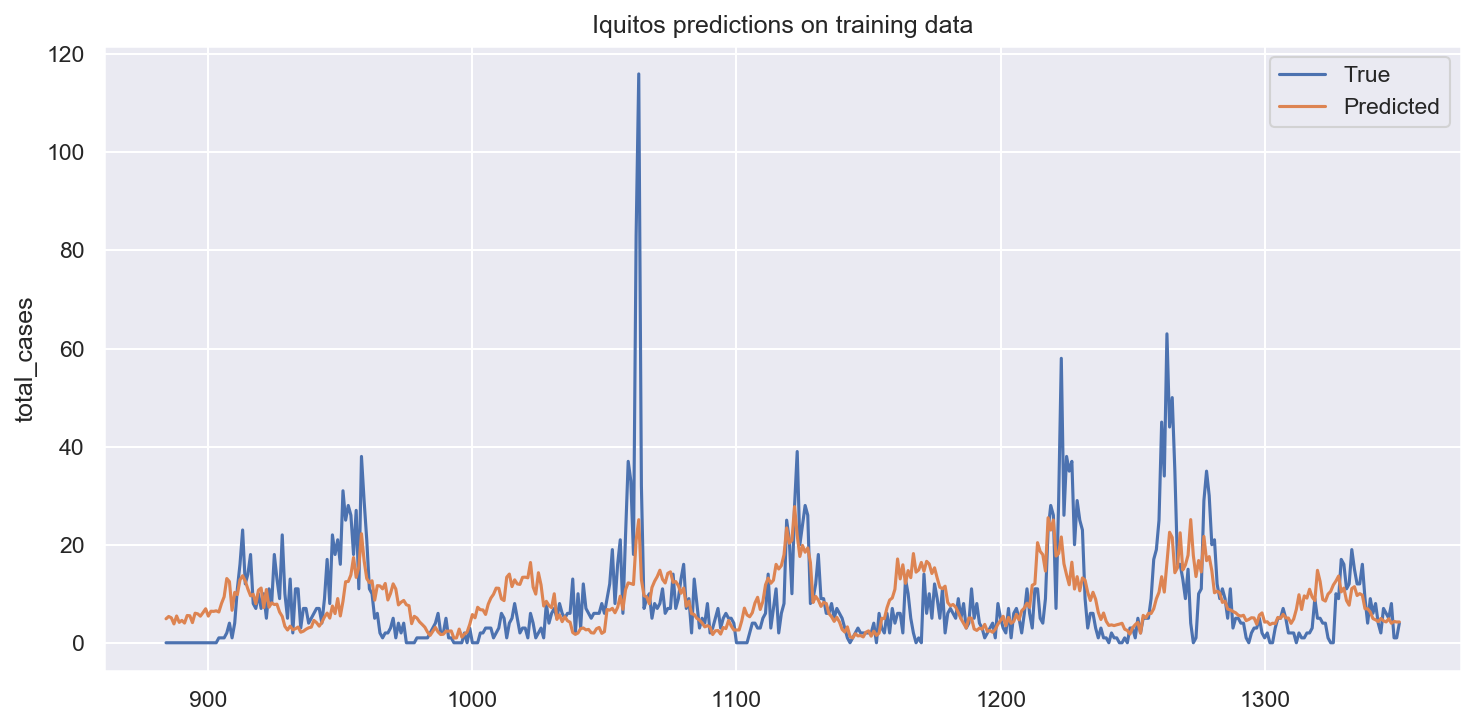

In [194]:
model_iq.fit(X_train_iq, y_train_iq)
y_val_iq = model_iq.predict(X_train_iq).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = X_train_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = X_train_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall performance

In [210]:
sj_ratio = len(X_train_sj) / len(X_train)
iq_ratio = len(X_train_iq) / len(X_train)

sj_ratio * np.mean(cv_sj['test_score']) + iq_ratio * np.mean(cv_iq['test_score'])

-21.06050292529862

## Submission

In [248]:
sub = build_submission(
    model_sj,
    model_iq,
    X_test_sj,
    X_test_iq,
    'data/raw',
    PRED_PATH,
    'stacked_negbin_prog_lag'
)

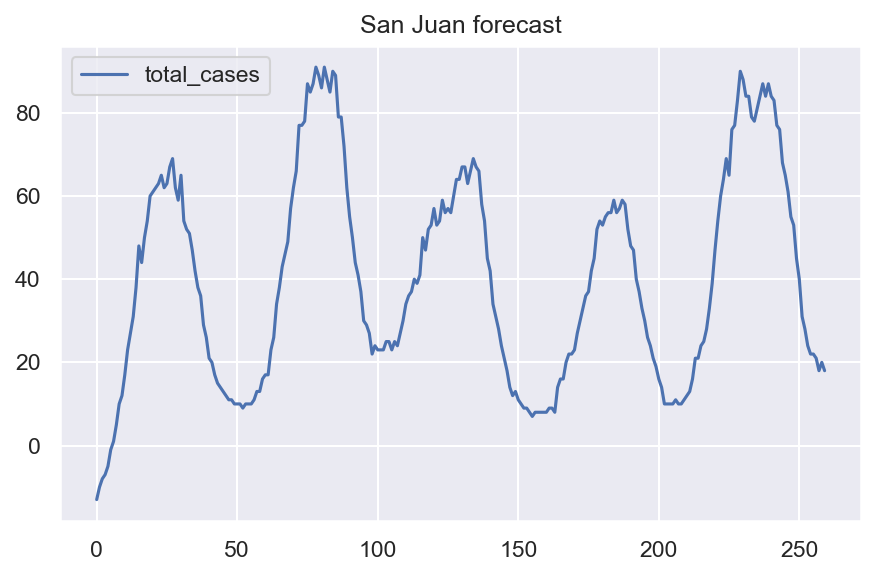

In [246]:
sub[sub['city'] == 'sj'].plot(
    y = 'total_cases',
    title = 'San Juan forecast'
)

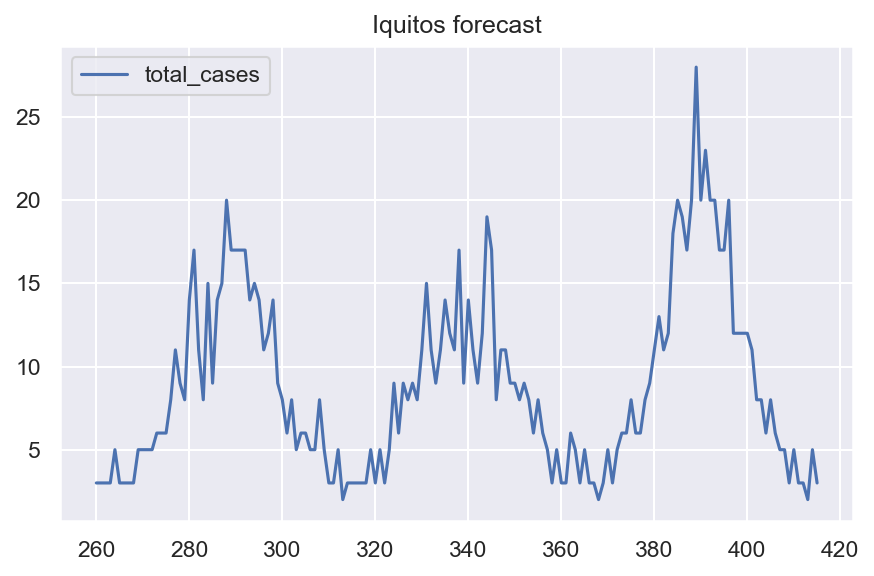

In [247]:
sub[sub['city'] == 'iq'].plot(
    y = 'total_cases',
    title = 'Iquitos forecast'
)